# Big Data Management and Data Visualisation


# Introduction

The dataset used in this report is from Kaggle's [**Berlin Airbnb Data**](https://www.kaggle.com/brittabettendorf/berlin-airbnb-data) whose aim is to investigating Airbnb activity in Berlin, Germany. There are 6 files summing up to 126 columns.

## Datasets Content
The datasets were scraped on November 07th, 2018 and contain detailed listings data, review data and calendar data of current Airbnb listings in Berlin.

## Aim
The aim of this report is to undertake data analysis and data visualization on this big data using *pyspark* a big data library from Apache. The following are some of the insights we would like to get from the dataset:
1. What are the busiest times of the year to visit Berlin? By how much do prices spike?
2. Can we uncover trends in listings of Airbnb visitors to Berlin?
3. Using the listings variables, can we predict the price of a listings?

# Libraries

In [1]:
# Built-in libraries
import warnings # For warnings filterings

# Data Analysis and Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Libraries Configuration

In [2]:
pd.set_option("display.max_columns", None) # Display all columns withouth trancating
pd.set_option("display.max_colwidth", None) # Set no default column width

# Find pyspark
import findspark
findspark.init()

# Set up pyspark
from pyspark.sql import SparkSession
## Configure SparkSession
spark = SparkSession.builder.appName(
    "Big Data Management and Data Visualisation"
).config(
    "spark.some.config.option",
    "some-value"
).getOrCreate()


ModuleNotFoundError: No module named 'findspark'

### Advanced Libraries and Functions

In [ ]:
# Import pyspark data cleaning libraries
from pyspark.sql.types import (StructType, 
                               StructField, 
                               StringType, 
                               IntegerType, 
                               FloatType)

# Import pyspark sql functions
from pyspark.sql.functions import (isnan, 
                                   when, 
                                   count, 
                                   col)

%matplotlib inline
plt.style.use("fivethirtyeight")

## Machine Learning Libraries

In [ ]:
# Feature Engineering
from pyspark.ml.feature import (OneHotEncoder, # For Categorical Encoding
                                VectorAssembler, #Assemble predictors and target 
                                StringIndexer, #map column to ML column of label indices 
                               
                               )

# Machine Learning algorithms methods
from pyspark.ml.regression import( DecisionTreeRegressor, 
                                  LinearRegression, 
                                  RandomForestRegressor, 
                                  GBTRegressor)
# Evaluation Metrics
from pyspark.ml.evaluation import RegressionEvaluator

# Data Loading

In this report, we will only consider the `listings.csv` dataset to tackle the big data analysis and visualization. The dataset contains airbnb listings in Berlin, Germany and has 16 columns

In [ ]:
# Read the CSV with pyspark
listings = spark.read.csv("data/listings.csv", header=True)

# Explore the first 5 rows
listings.limit(5).toPandas()

# Exploratory Data Analysis

We will first check the number of columns and the number of rows present in the `listings` dataset

## The shape of the dataset

In [ ]:
# Check number of rows and columns
listings.count()

This dataset has $22583$ rows and 16 columns (as was seen on the first 5 rows). The column names are self explanatory hence no further description for the columns.

## The dataset schema.
The dataset schema shows the column names and their corresponding data types, this is an initial step that can aid in cleaning the dataset to make sure the columns are with their correct data types as needed.

In [ ]:
# Check the listings schema
listings.printSchema()

AS shown, all columns have `string` data type, we will reload the data with the correct data types

### Initial Data Cleaning

In [ ]:
# Create the correct schema for the dataset
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name",StringType(), True),
    StructField("host_id", IntegerType(), True),
    StructField("host_name", StringType(), True),
    StructField("neighbourhood_group", StringType(), True),
    StructField("neighbourhood", StringType(), True),
    StructField("latitude",FloatType(), True),
    StructField("longitude", FloatType(), True),
    StructField("room_type", StringType(), True),
    StructField("price", IntegerType(), True),
    StructField("minimum_nights", IntegerType(), True),
    StructField("number_of_reviews", IntegerType(), True),
    StructField("last_review", StringType(), True),
    StructField("reviews_per_month", FloatType(), True),
    StructField("calculated_host_listings_count", IntegerType(), True),
    StructField("availability_365", IntegerType(), True), 
])

# Redefining the dataframe with correct column labels 
listings = spark.read.csv("data/listings.csv", header=True, schema=schema)
# Check for the schemas
listings.printSchema()

# Exploratory Data Analysis

In [ ]:
# Check the head (first 5 rows)
listings.limit(5).toPandas()

In [ ]:
## Check Info()
listings.toPandas().info()

After cleaning the data types, we can see that some columns contain missing values.

In [ ]:
listings.select([
    count(
        when(
            isnan(column)| col(column).isNull(), 
            column
        )
    ).alias(
        column
    ) for column in listings.columns
]).toPandas().T

The missing values are minimum in all columns except for `last_review` and `reviews_per_month` columns.For other columns, missing values were ranging from 30-66. The reason for very many missing values in the `last_review` and `reviews_per_month` might be due to majority of human beings failing to leave a review once served. We will have to handle missing values (there are various ways of handling missing values such as imputing or droping missing values) To to this, we will remove the missing values

In [ ]:
# Remove missing vallues
listings = listings.na.drop()

# Check if the above step removed missing values
listings.select([
    count(
        when(
            isnan(column)| col(column).isNull(), 
            column
        )
    ).alias(
        column
    ) for column in listings.columns
]).toPandas().T

We do not have missing values. Lets check for descriptive statistics of the dataframe.

In [ ]:
listings.summary().toPandas().set_index("summary").T

The summary statistics show that there may be outliers in the dataset. Outliers is detected by the quatiles, min and max. Visualizations will help us determine the outliers present in the variables of this dataset.

`room_type` column contains information of a listings room type, we will check the unique room types present in the AirBnB Berlin

In [ ]:
listings.select("room_type").distinct().show()

In the entire dataset, there are 3 room types (*Shared room*, *Entire home/apt*, and *Private Room*). We will use Python Software specifically (matplotlib and Seaborn libraries) to tackle the data visualization.

For the room type, lets see the counts per room type and also visualize in order to see the proportion

In [ ]:
listings.groupBy("room_type").count().show()

**Private room dominates** the room type, shared rooms are the least with 218 listings. We will draw a piechart in order to see the visualization of the proprotion.

In [ ]:
ax=listings.groupBy(
    "room_type"
).count().toPandas().plot.barh(legend=False)
plt.ylabel("Counts")
plt.xlabel("Room type")
plt.title("Number of Listings per Room Type")
ax.set_yticklabels(["Shared Room", "Entire Home/Apt", "Private Room"])
plt.show()

Private Room and Entire Home/Apt have a small difference. Both private Room and Entire Home make about 99% of the listings in the Air BNB listings.

### How does the Room Type Affect the price of a listings?

To answer this question, we will plot the distribution of price per room type.

In [ ]:
room_price = listings.select("room_type", "price").toPandas()
sns.displot(
    room_price, 
    x="price",
    aspect=2,
    hue="room_type"
)
plt.show()

Due to outliers, the histogram doesn't look informative. Lets handle the outliers by removing listings whose price are over 200 dollars

In [ ]:
# Filter out listings with over $200 price
listings = listings.filter(listings["price"]<=200)

#select the room_type and price Columns
room_price = listings.select("room_type", "price").toPandas()

# Display the price distribution per room type
sns.displot(
    room_price, 
    x="price",
    aspect=2,
    hue="room_type",
    kde=True
)
plt.title("Price Distribution per Room Type")
plt.show()

Private Rooms are cheaper while Entire Home/apt are very expensive. Due to less shared rooms, their insight is not seen in the distribution, therefore we will plot a barplot of `room_type` vs `price` to see how `room_type` affect the price of a listing.

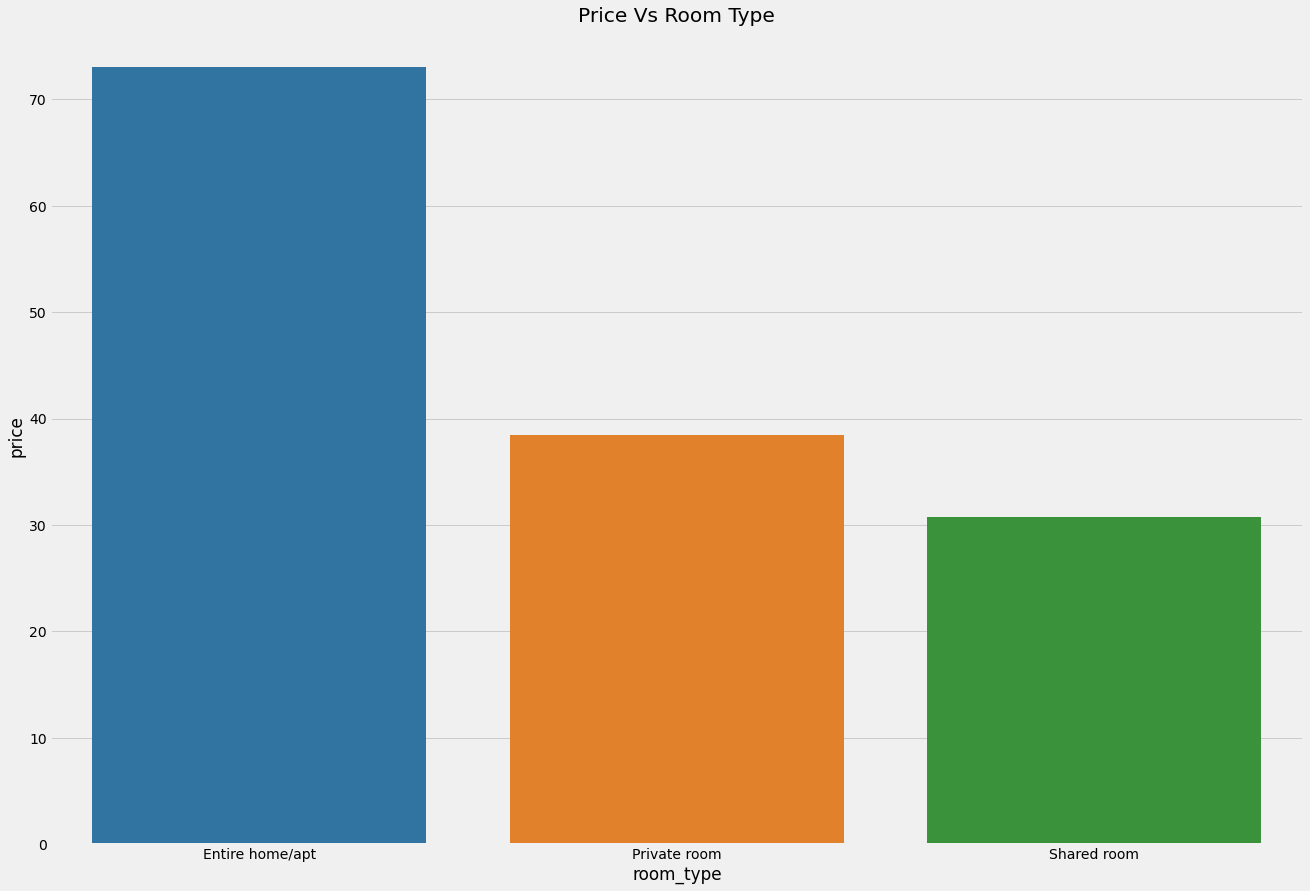

In [148]:
fig,ax = plt.subplots(figsize=(20,14))
sns.barplot(x='room_type',y='price', data=room_price, palette="tab10",ci = None)
plt.title("Price Vs Room Type")
plt.show()

Entire home/apt are most expensive, followed by private rooms then shared rooms are cheapest.

### How does minimum Nights affect listing price per Room type?

To answer this we will plot scatter plot for listing price as a function of minimum nights per room type

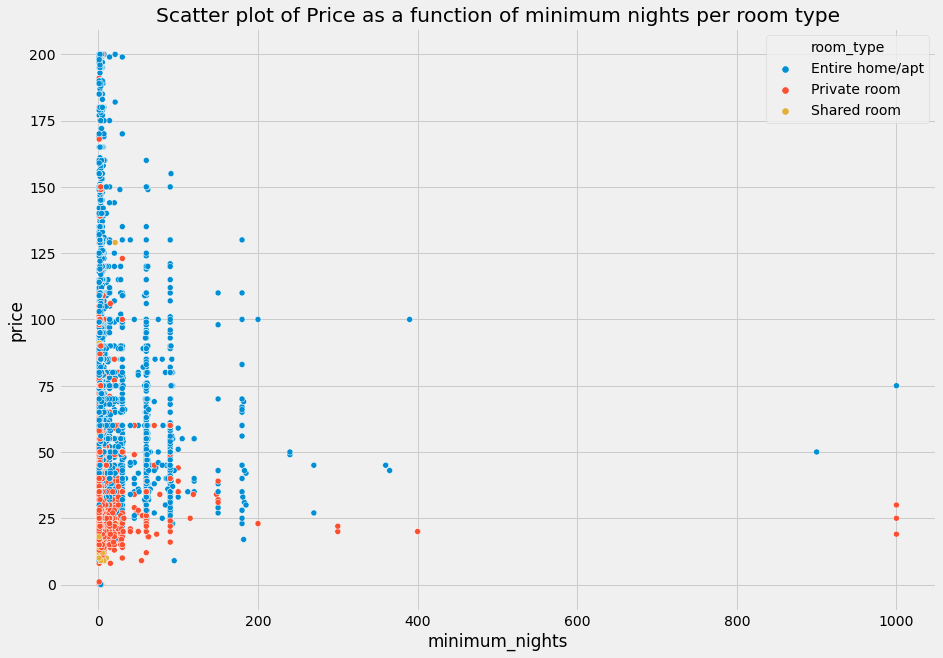

In [149]:
fig, ax = plt.subplots(figsize=(14,10))
room_night_price = listings.select("room_type", "minimum_nights", "price").toPandas()
sns.scatterplot(
    data=room_night_price,
    x="minimum_nights",
    y="price",
    hue="room_type"
)
plt.title("Scatter plot of Price as a function of minimum nights per room type")
plt.show()

From this scatter plot the relashionship is harder to tell, but what can be seen is that indivials in shared rooms paid less and spend less night.

### How does location affect the listing price?

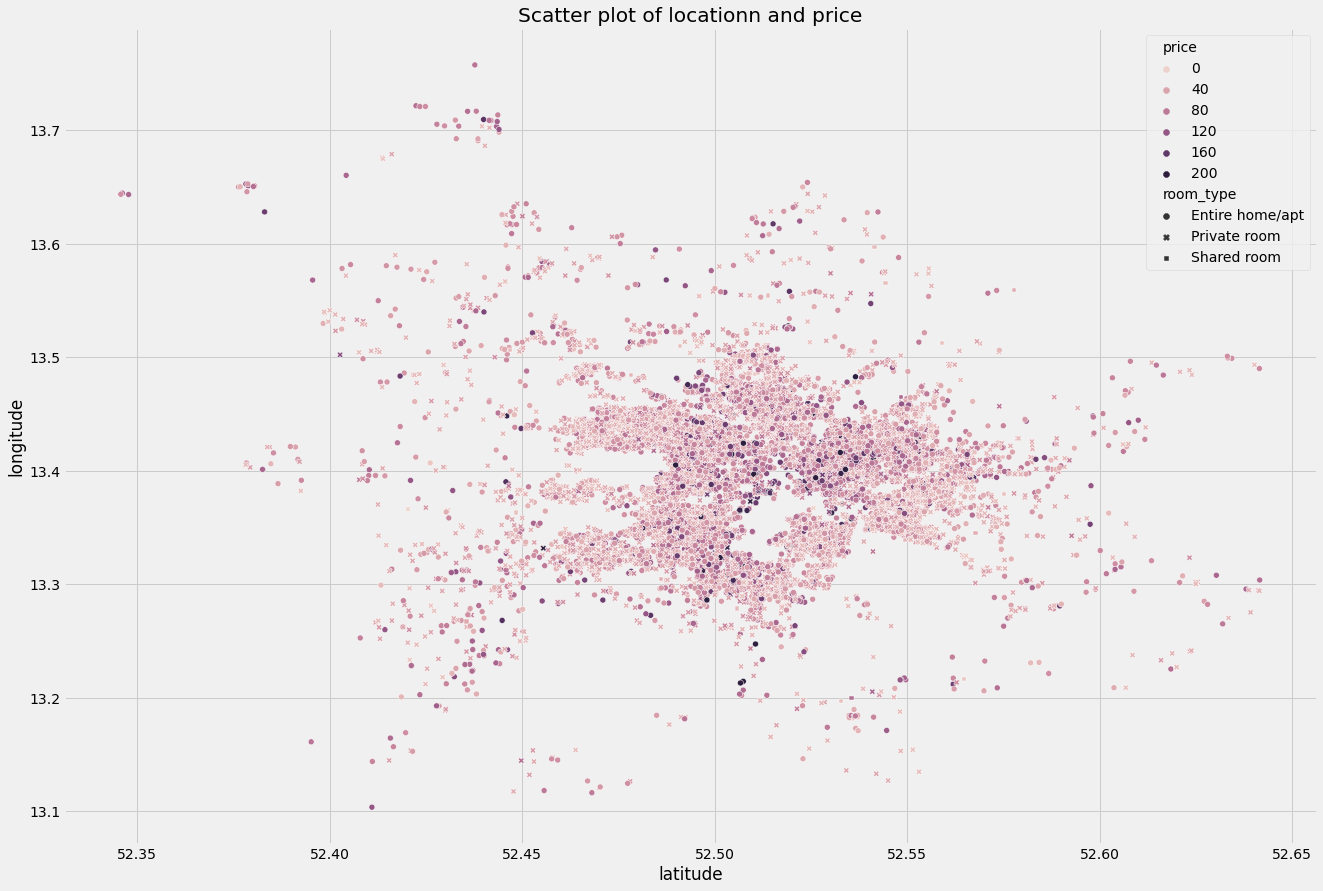

In [150]:
fig, ax = plt.subplots(figsize=(20,14))
locations = listings.select("latitude", "longitude", "price", "room_type").toPandas()
sns.scatterplot(
    data=locations,
    x="latitude",
    y="longitude",
    hue="price",
    style="room_type"
)
plt.title("Scatter plot of locationn and price")
plt.show()

From this map, we can see that listings price in the Central Berling are higher that other locations

### How does room availability affect the price?

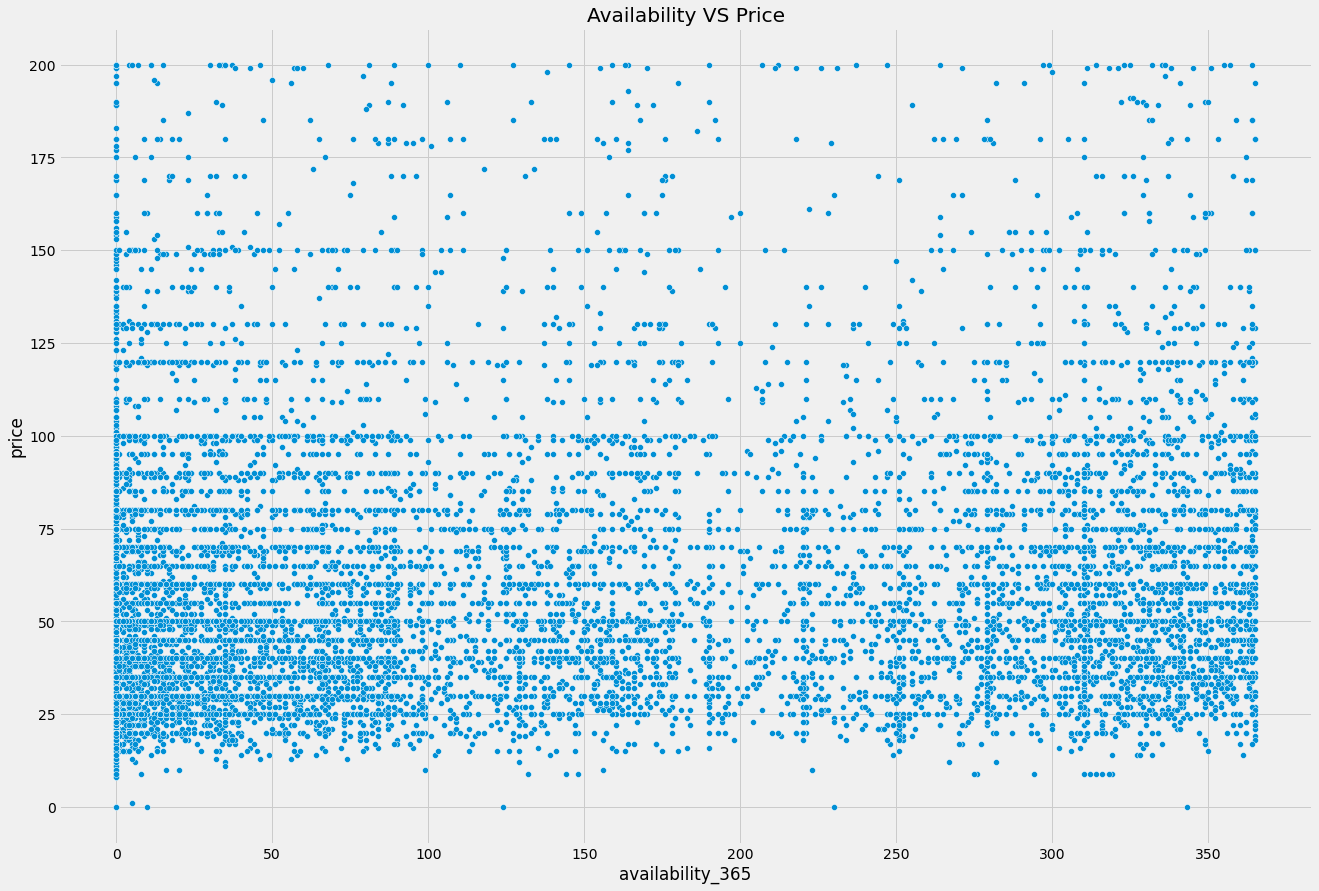

In [151]:
fig, ax = plt.subplots(figsize=(20,14))
locations = listings.select("price", "availability_365").toPandas()
sns.scatterplot(
    data=locations,
    x="availability_365",
    y="price"
)
plt.title("Availability VS Price")
plt.show()

There is no relationship

### Entire Data Set Scatterplot matrix and correlation

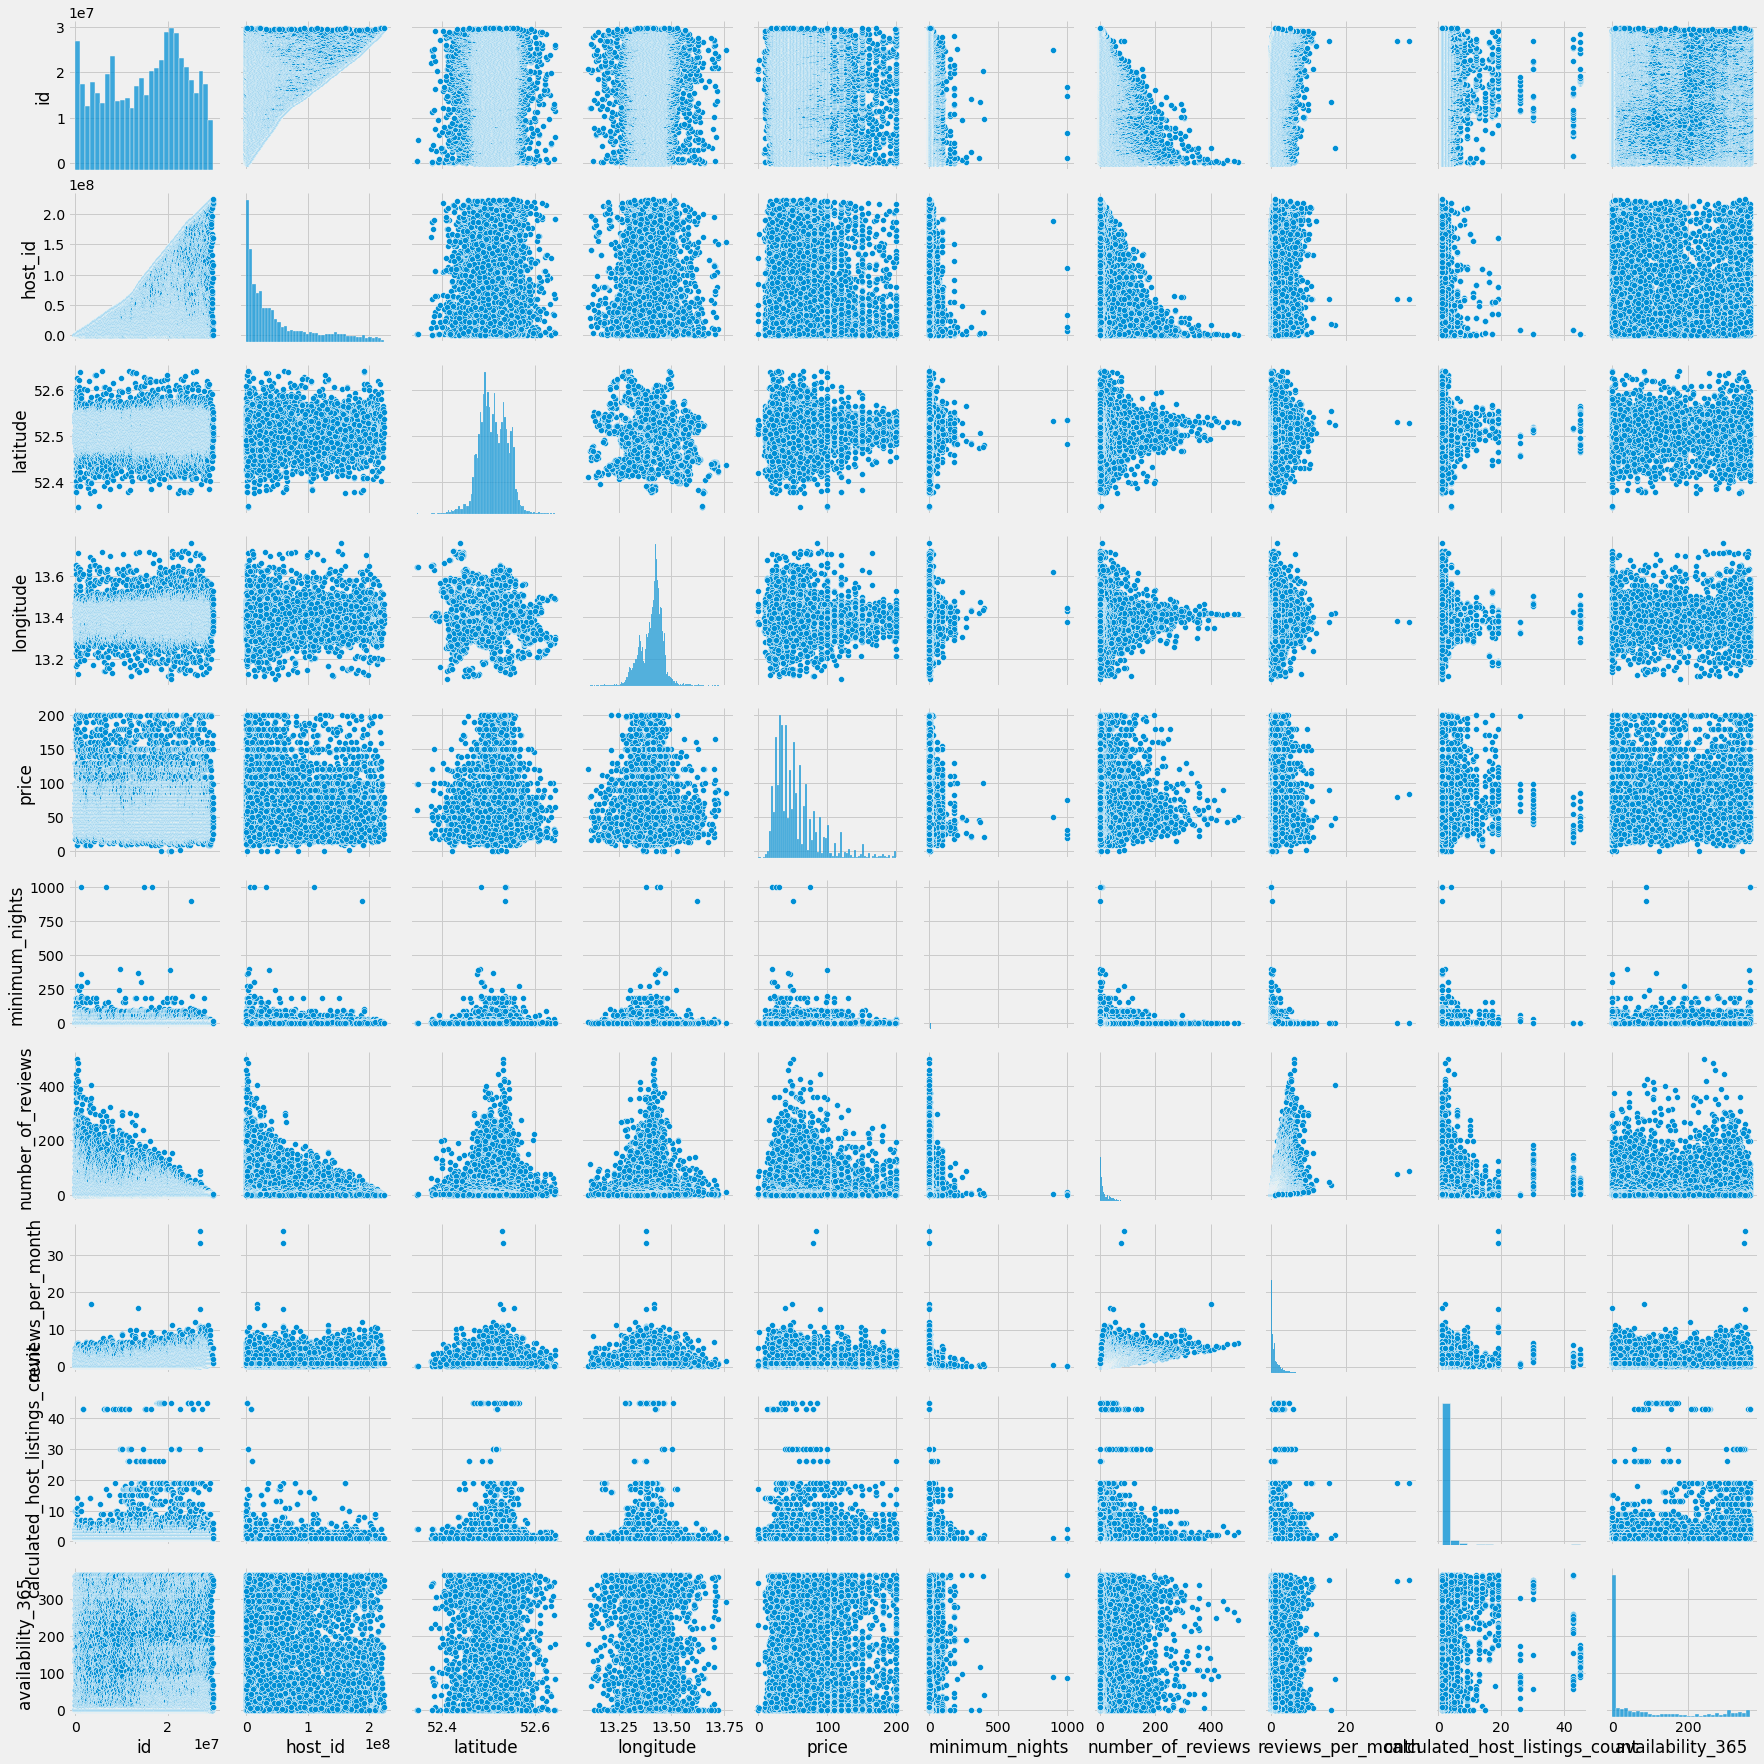

In [152]:
sns.pairplot(
    listings.toPandas()
)
plt.show()

From the scatter matrx we can see that majority of the clumns are right skewed, such as `price`, `calculated_host_listings`, `availability_365` etc. In terms of correlation, it is harder to tell the correlations hence week correlation is seen among the columns therefore, it is important to visualize the correlations of the columns.

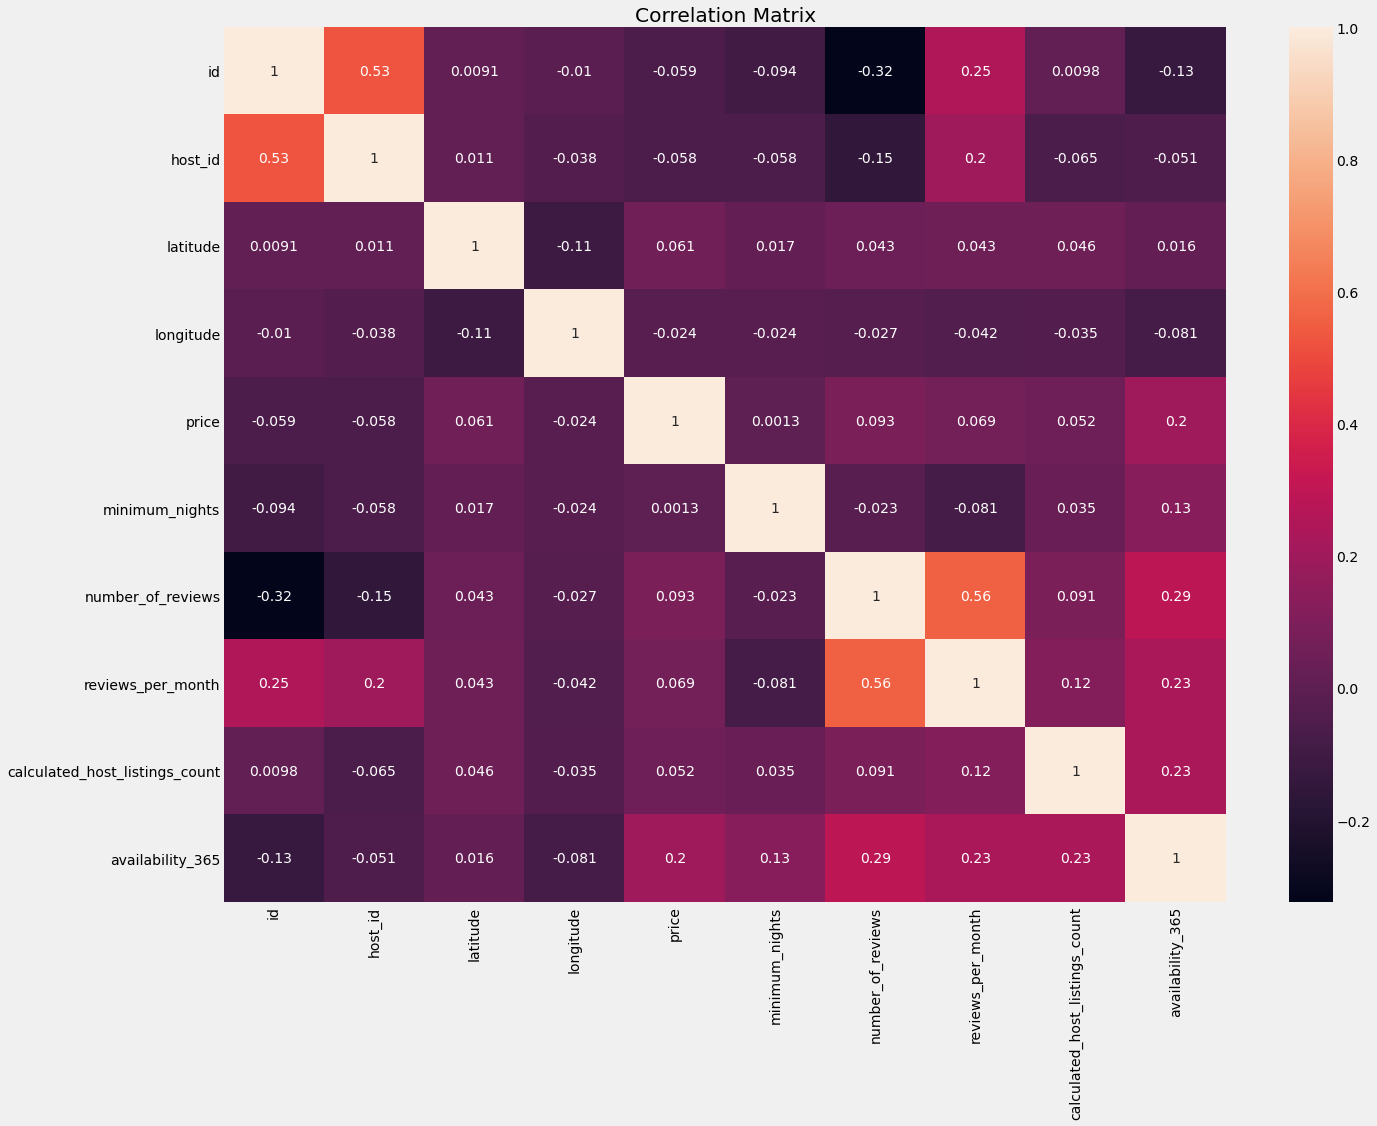

In [153]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(listings.toPandas().corr(), annot=True)
plt.title("Correlation Matrix")
plt.show()

We can see that there is a moderate correlation between the `reviews_per_month` and `number_of_reviews` columns, other columns show week correlations.

### Neighbourhood

The neighbourhood column indicates the neighbourhood where the listings is situated. Let's check how many neighbourhood and neighbourhood groups are available in our dataset.

In [154]:
listings.groupBy("neighbourhood").count().orderBy("count", ascending=False).show()

+--------------------+-----+
|       neighbourhood|count|
+--------------------+-----+
|Tempelhofer Vorstadt| 1080|
|Frankfurter Allee...| 1055|
|      Alexanderplatz|  884|
|        Reuterstraße|  815|
|             Rixdorf|  745|
|Neuköllner Mitte/...|  665|
|     Brunnenstr. Süd|  622|
|Frankfurter Allee...|  597|
|Prenzlauer Berg S...|  534|
|   Schillerpromenade|  534|
|südliche Luisenstadt|  530|
|Prenzlauer Berg N...|  512|
| Prenzlauer Berg Süd|  456|
|     Schöneberg-Nord|  450|
|     Wedding Zentrum|  424|
|nördliche Luisens...|  419|
|         Moabit West|  399|
|      Schöneberg-Süd|  397|
|      Helmholtzplatz|  362|
|Prenzlauer Berg Nord|  348|
+--------------------+-----+
only showing top 20 rows



There are many neighbourhoods in airbnb Berlin, Germany Listings with many listings from **Tempelhofer Vorstadt** neighbourhood. let us visualize this neighbourhoods in Berlin.

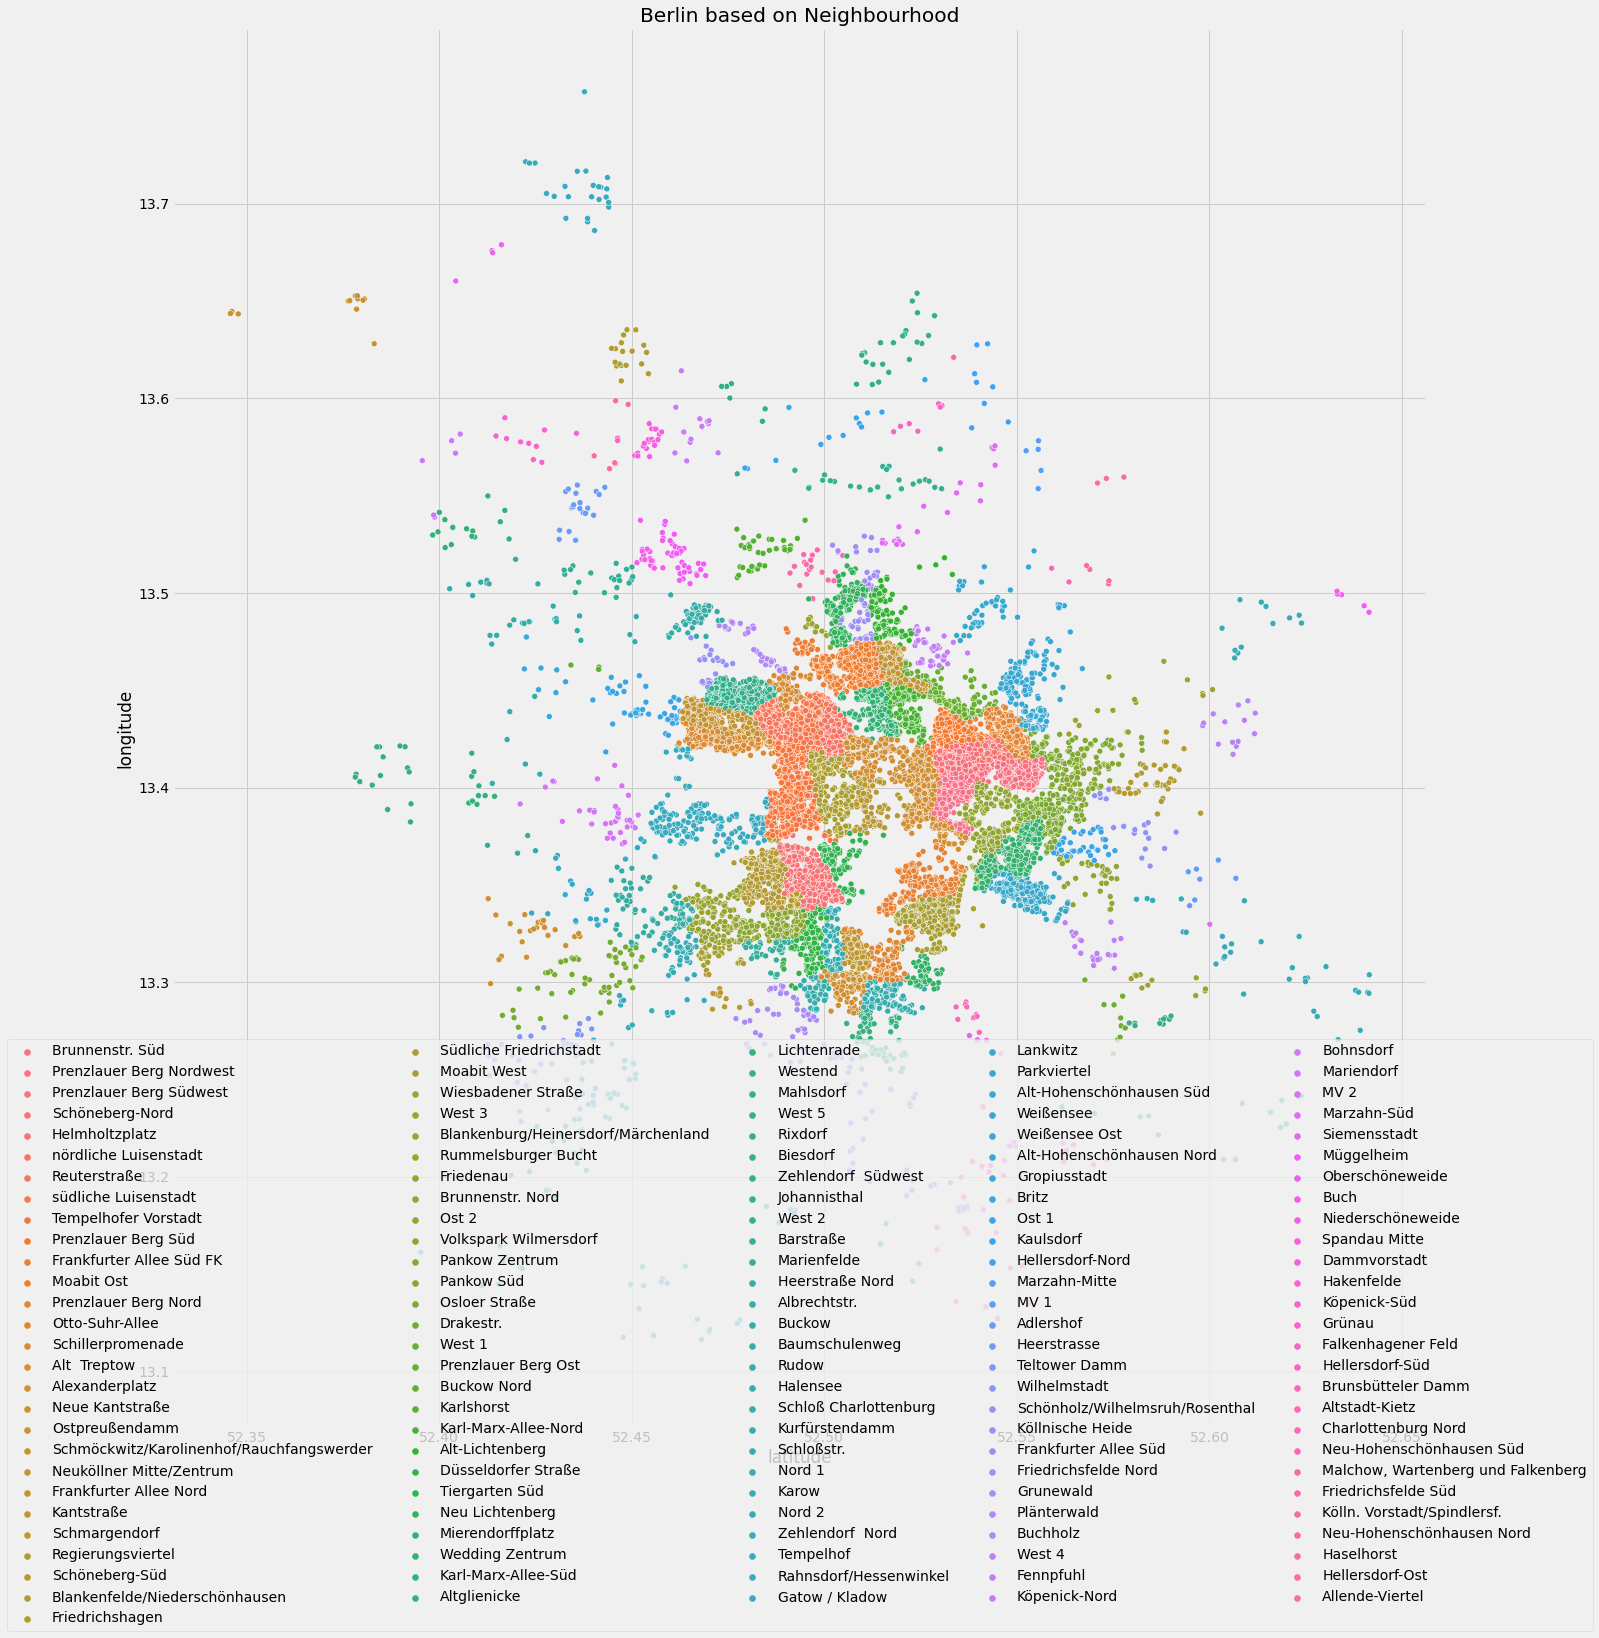

In [155]:
fig, ax = plt.subplots(figsize=(20,24))
neighbourhood = listings.select("latitude", "longitude", "price", "neighbourhood").toPandas()
sns.scatterplot(
    data=neighbourhood,
    x="latitude",
    y="longitude",
    hue="neighbourhood"
)
plt.title("Berlin based on Neighbourhood")
plt.legend(loc="lower center", ncol=5, bbox_to_anchor=(0.5, -0.15))
plt.show()

#### Effect of neighbourhood on price

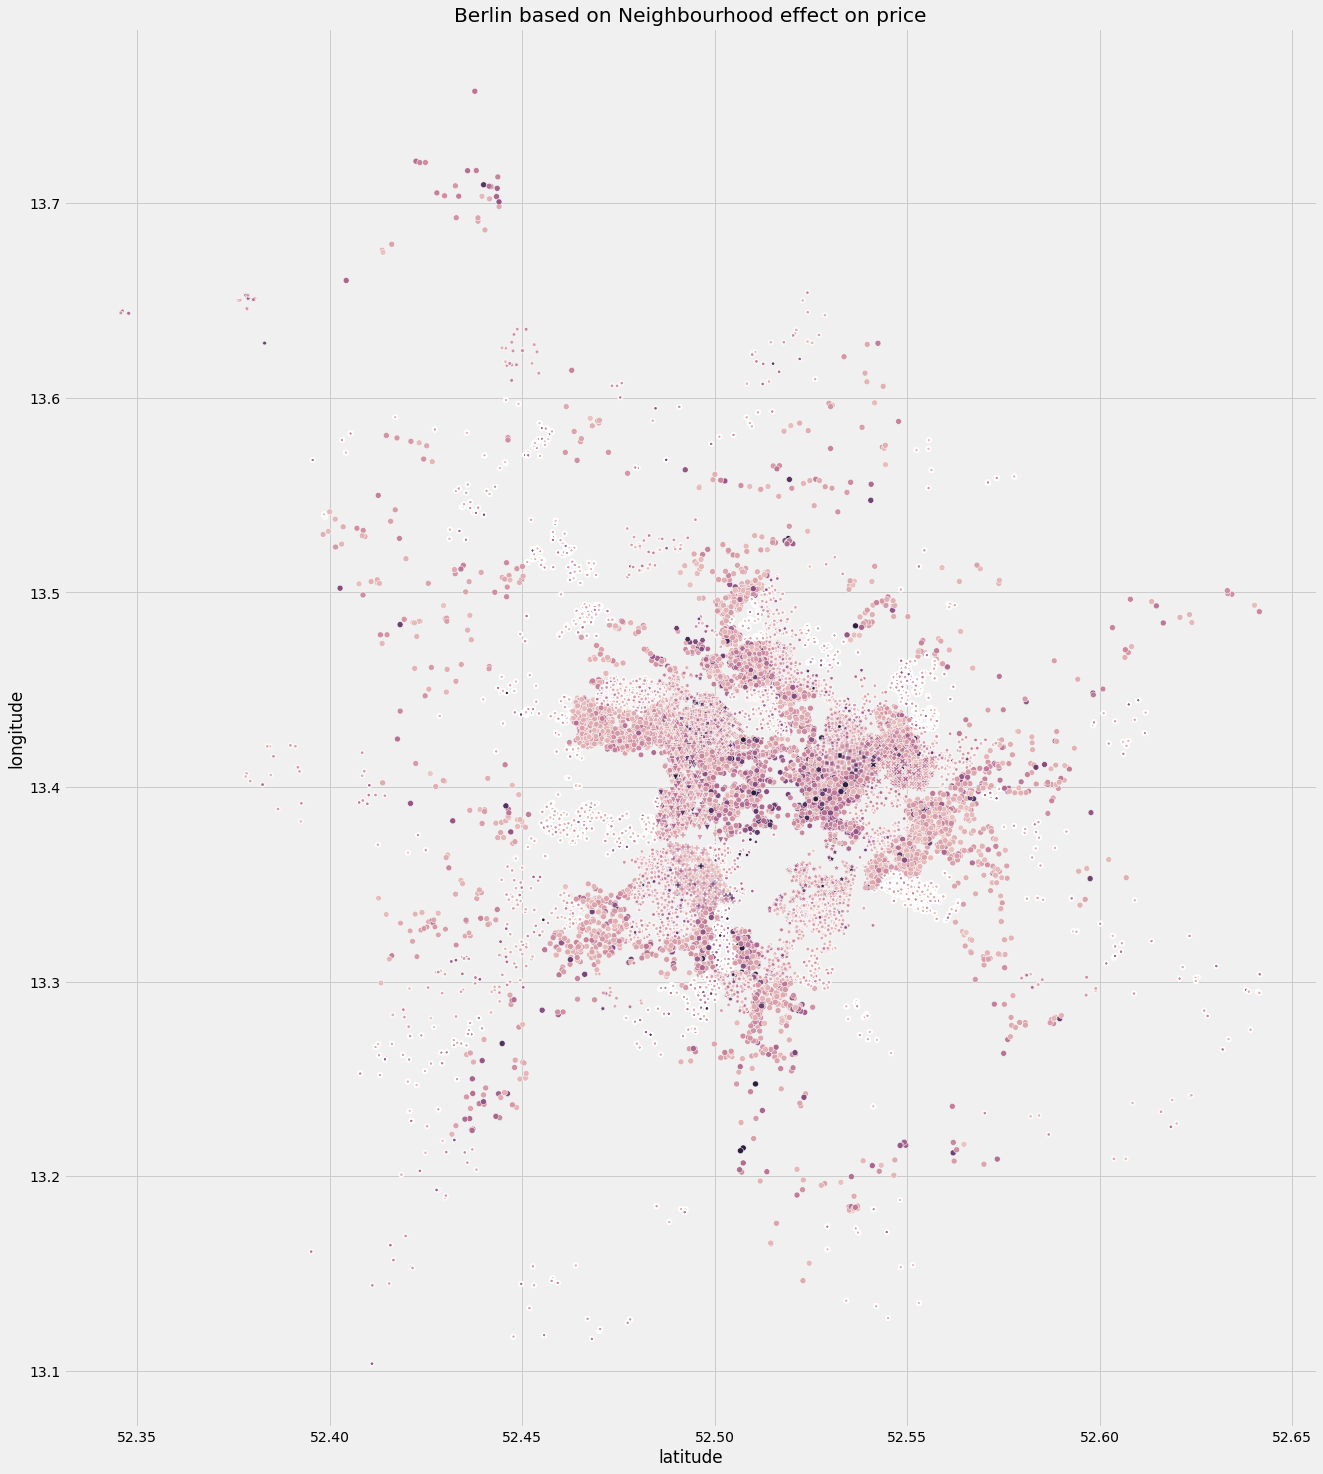

In [156]:
fig, ax = plt.subplots(figsize=(20,24))
sns.scatterplot(
    data=neighbourhood,
    x="latitude",
    y="longitude",
    style="neighbourhood",
    hue="price",
    legend=False
)
plt.title("Berlin based on Neighbourhood effect on price")
plt.show()

The central neighbourhoods in Berlin are very expensive While the neighbourhoods that are further away are least expensive.

# Machine Learning

For this regression was the best data analysis task to undertake in order to predict the `price` of a listing using some of the airbnb listing variables. This is because there are known variables and the variables are explanatory variables for the `price`, that is, using the variables, we can determine/predict the price of a listing in Berlin.

## Feature Engineering
The feature engineering involves encoding our categorical features. The reason for encoding is to make the categorical columns be numerical since Most machine learning algorithms cannot handle `string` datatypes, they only handle numerical columns.

In [157]:
# Create a list of categorical features
categorical_columns = [
    column[0] for column in listings.dtypes if column[1]=="string"
]
categorical_columns

['name',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'room_type',
 'last_review']

We have 6 Categorical Columns in our dataset. We will encode these categorical columns with OneHotEncoder which maps a column of category indices to a column of binary vectors

In [158]:
# Loop every categorical column and encode 
for categorical_column in categorical_columns:
    str_idx = StringIndexer(
        inputCol=categorical_column, 
        outputCol=categorical_column+"_str_idx",
    )
    str_idx_model = str_idx.fit(listings)
    listings = str_idx_model.transform(listings)
    
    ohc = OneHotEncoder(
        inputCol=categorical_column+"_str_idx",
        outputCol=categorical_column+"_encoded", 
        dropLast=False
    )
    ohc_model = ohc.fit(listings)
    listings=ohc_model.transform(listings)
    
# Preview the listings dataframe
listings.limit(2).toPandas()

id                                              name  host_id host_name  \
0  2015  Berlin-Mitte Value! Quiet courtyard/very central     2217       Ian   
1  2695                Prenzlauer Berg close to Mauerpark     2986   Michael   

  neighbourhood_group             neighbourhood   latitude  longitude  \
0               Mitte           Brunnenstr. Süd  52.534538  13.402557   
1              Pankow  Prenzlauer Berg Nordwest  52.548512  13.404552   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0  Entire home/apt     60               4                118  2018-10-28   
1     Private room     17               2                  6  2018-10-01   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               3.76                               4               141   
1               1.42                               1                 0   

   name_str_idx  \
0        3130.0   
1       11792.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                name_encoded  \
0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)   
1  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)   

   host_name_str_idx  \
0              422.0   
1                2.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           host_name_encoded  \
0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)   
1  (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

After encoding the categorical features, we will select the predictors that will be used in the machine learning model..

In [170]:
# Select all important Columns
all_columns = []
for column in listings.columns:
    if not column.endswith("encoded"):
        if column not in [
            "id", "name", "name_str_idx", 
            "name_encoded", "host_id", "host_name", 
            "host_name_str_idx", "host_name_encoded",
            "last_review", "last_review_str_idx", "last_review_encoded",
            "neighbourhood_group","neighbourhood","room_type",
            
        ]:
            all_columns.append(column)
all_columns

['latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'neighbourhood_group_str_idx',
 'neighbourhood_str_idx',
 'room_type_str_idx']

In [175]:
# Select Feature columns
feature_columns = all_columns[:]
feature_columns.remove("price")
feature_columns

['latitude',
 'longitude',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'neighbourhood_group_str_idx',
 'neighbourhood_str_idx',
 'room_type_str_idx']

After identifying the needed features, we will create a vector assembler. Vector Assembler is important in creating machine learning data which requires two columns only, that is, features and "price:

In [178]:
# Create VectorAssembler of features
vectorassembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create Vector assembler dataframe
listings_va = vectorassembler.transform(
    listings.select(all_columns)
).select("features", "price")
listings_va.show(10)

+--------------------+-----+
|            features|price|
+--------------------+-----+
|[52.5345382690429...|   60|
|[52.5485115051269...|   17|
|[52.5349960327148...|   90|
|[52.4988555908203...|   26|
|[52.5431556701660...|   42|
|[52.5330314636230...|  180|
|[52.5478477478027...|   70|
|[52.5047912597656...|   90|
|[52.5290718078613...|   45|
|[52.4954757690429...|   49|
+--------------------+-----+
only showing top 10 rows



In machine learning, models need to be evaluated. We can do this in our dataset by spliting the dataset into train set (which will be used for training/fitting the machine learning model) and test set (this will be used for prediction and evaluating the model)

In [180]:
# Split the dataset
train, test = listings_va.randomSplit([.7, .3])

We are now ready to start the machine learning process (training machine learning models). For this task the following algorithms will be used then from them we will select the model that best predicts and best trains Berlin Airbnb listings to determine price:
1. Linear Regression algorithm
2. Decision Tree Regression algorithm
3. Random Forest Regression algorithm
4. Gradient Boosting Algorithm

#### Models training 

In [185]:
# Create models
## 1. Linear Regression
lr = LinearRegression(labelCol="price").fit(train)
print(f"""====TRAINING SUMMARY====
Coefficients: {lr.coefficients}
Intercept: {lr.intercept}
RMSE: {lr.summary.rootMeanSquaredError}
R^2: {lr.summary.r2}""")

====TRAINING SUMMARY====
Coefficients: [11.284613986400256,-7.575523008979866,-0.07860852087404936,0.0006569894673714227,0.9122508696064605,-0.4670395933089027,0.047203307222742616,-0.8422959076017835,-0.09870069828624466,29.407928272937674]
Intercept: -450.4937747200701
RMSE: 27.824356008934366
R^2: 0.269926612942739


`LinearRegression` model has an approximate of 27.82 Root Mean squared error, RMSE measures the differences between predicted values by the model and the actual values. The models $R2$ is 27%, that means that  21% of the variability in `price` can be explained using the model. We will check for other models too. we will set `maxBins=136` since there are 136 neighbourhoods.

In [193]:
# Create models
## 2. Decision Tree Regression: s
dtr = DecisionTreeRegressor(labelCol="price", maxBins=136).fit(train)
rfr = RandomForestRegressor(labelCol="price", maxBins=136).fit(train)
gbr = GBTRegressor(labelCol="price", maxBins=136).fit(train)

#### Predictions

It is time for predictions, with all models trained, we will predict using the `test` and then chose the model that has lowest RMSE.

In [196]:
# Models Prediction
lr_preds = lr.transform(test)
dtr_preds = dtr.transform(test)
rfr_preds = rfr.transform(test)
gbr_preds = gbr.transform(test)

# Evaluate models
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_preds)
dtr_rmse = evaluator.evaluate(dtr_preds)
rfr_rmse = evaluator.evaluate(rfr_preds)
gbr_rmse = evaluator.evaluate(gbr_preds)
## print RMSEs
print(f"""=====MODELS RMSE=====
Linear Regression RMSE:\t\t\t {lr_rmse}
Decision Tree Regression RMSE:\t\t {dtr_rmse}
Random Forest Regression RMSE:\t\t {rfr_rmse}
Gradient Boosting Regression RMSE:\t {gbr_rmse}""")

=====MODELS RMSE=====
Linear Regression RMSE:			 27.88681854886321
Decision Tree Regression RMSE:		 26.097553532137486
Random Forest Regression RMSE:		 25.79585541861001
Gradient Boosting Regression RMSE:	 25.919504517324604


Random Forest Regressor seems to be performing better that the rest of the models with an approximate Root Mean Squared error of 25.80

# Analyzing the findings

Throughout this report we have used various methods to uncover insights from the airbnb Berline listings dataset using big data library `pyspark` and other data visualization libraries such as `matplotlib` and `seaborn`. Pyspark has been used entirely for everything dealing with spark dataframes.
The following are the findings and methods used in getting the findings:
- The data set had 16 columns and 22583 rows, this was determined py `.count()` method of `pyspark` dataframe. Using pyspark for large data set minimizes memory consumption and a data with over 1000 rows will work great with pyspark but lag in `pandas`.
- In the preprocessing step, we found out that every column in the dataset had a missing value. The number of missing values were highest in the `last_review` and `reviews_per_month` with over 3940 missing values. For other columns, missing values were ranging from $30-66$. The reason for very many missing values in the `last_review` and `reviews_per_month` might be due to majority of human beings failing to leave a review once served. We removed all rows having missing values since the proportion of missing values to the entire dataset was negligible.
- There are $3$ distinct room types in the Berlin AirBNB listings, these are:
  - *Shared Rooms*: has the least number of listings, and also the cheapest in terms of `price`
  - *Entire Home/apt*: these are the second largest `room_types` constitution almost 46% of the listings. We also found out that *Entire Home*
  - *Private Room*: majority of the rooms belongs to this room type.
> To Uncover the room type proportings we used the methods such as grouping the dataset by `room_type` using `.groupBy()` method and counting the number of items per the formed groups using the `.count()` method. All the stated functions are pyspark dataframe methods.

- The central part of Berlin had the most expensive listings, this was uncovered by ploting a scatterplot of `latitude` vs `longitude` column and coloring by the `price` dataset to determine the effect of location on airbnb listing price.
- Due to their nature, `number_of_reviews` and `reviews_per_month` had a moderate correlation of $0.56$. The correlation strength was determined by seaborns `heatmap()` method, we had to tranform the pyspark dataframe to a pandas dataframe.
- Regression was the most effective data analysis task to undertake in order to use the variables in the airbnb Berling listing dataset to predict the `price` of a listing in Berlin. Machine learning algorithms used in this report were:
  - Linear Regression 
  - Decision Tree Regression
  - Random Forest Regression
  - Gradient Boosting Regression
- Random Forest was the best performing regression algorithm, it had the lowest RMSE.

## Recommendation
There are very many things that needs to be done in this report:
- This report only considered one dataset from the `listings.csv`, from the kaggle repository, there are 5 other files:
  - calendar_summary.csv
  - listings_summary.csv
  - neighbourhoods.csv
  - reviews.csv
  - reviews_summary.csv
  
> Considering all files might yield better results. for example the `calendar_summary.csv` might be used for time series forcasting.

- Hyperparameter tuning, though time consuming needs to be done to obtain best parameter that can be used to predict better `price`.